In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#This is an analysis of the K2 data for Neptune
#
#Data are from Rowe et al. 2017 
#  https://ui.adsabs.harvard.edu/?#abs/2017AJ....153..149R
#See Simon et al. 2016 for a published analysis and physical interpreatin
# http://adsabs.harvard.edu/abs/2016ApJ...817..162S


In [3]:
from astropy.table import Table
t = Table.read('K2Neptune_votable.vot')
t

BJD,Flux,e_Flux
d,,
float64,float32,float32
16.40017501,-0.00317,0.00036
16.40085596,-0.00292,0.00036
16.40153700,-0.00270,0.00036
16.40221805,-0.00265,0.00036
16.40289919,-0.00266,0.00036
16.40358023,-0.00245,0.00036
16.40426138,-0.00238,0.00036
16.40494242,-0.00241,0.00036


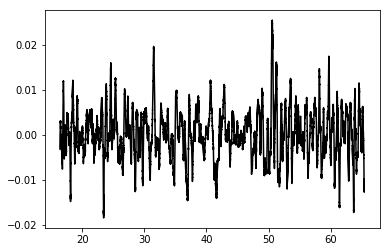

In [4]:
plt.plot(t['BJD'],t['Flux'],'k-')


(10, 25)

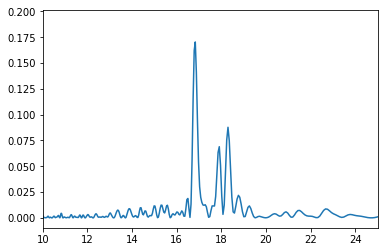

In [5]:
#make Lomb-Scargle
# See http://docs.astropy.org/en/stable/stats/lombscargle.html
from astropy.stats import LombScargle
frequency, power = LombScargle(t['BJD'], t['Flux'],t['e_Flux']).autopower()
# should change units properly instead of just multiplying...
period_hr=24.0/frequency
plt.plot(period_hr,power)
plt.xlim(10,25)
 

(0, 5)

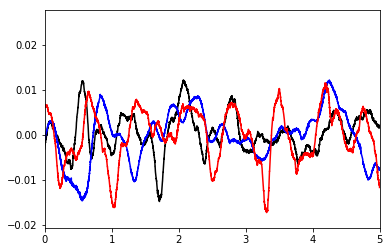

In [6]:
plt.plot(t['BJD']-16.4,t['Flux'],'k-',t['BJD']-36.4,t['Flux'],'b-',t['BJD']-60.4,t['Flux'],'r-')
plt.xlim(0,5)
#This should look something like Figure 1 of Simon et al. 

In [7]:
frequency.unit


Unit("1 / d")